# Libraries import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from typing import Optional

import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

# Visualizing functions

In [4]:
def countplot(column):
  # Plot the count of churned customers by gender
  plt.figure(figsize=(10, 6))
  ax = sns.countplot(data=recurrent_customers, x=column, hue='churn_nominal', palette='Blues')
  plt.title(f'Customer Churned by {column}', fontsize=16)
  plt.xlabel(f'{column}', fontsize=14)
  plt.ylabel('Count', fontsize=14)

  # Add percentages on top of bars
  total = len(recurrent_customers)
  for p in ax.patches:
      if p.get_height() > 0:  # Add this condition to skip bars with zero height
          percentage = '{:.1f}%'.format(100 * p.get_height() / total)
          x = p.get_x() + p.get_width() / 2 - 0.05
          y = p.get_y() + p.get_height()
          ax.annotate(percentage, (x, y), size=12)


  plt.show()

def continous_plot(column, binwidth = 2):
    #  Plot the distribution of customer_age by churn status
    plt.figure(figsize=(14, 6))

    # Histogram and KDE plot
    plt.subplot(1, 2, 1)
    sns.histplot(data=recurrent_customers, x=column, hue='churn_nominal', kde=True, palette='Blues', multiple='stack',binwidth=binwidth)
    plt.title(f'Distribution of {column} by Churn Status', fontsize=16)
    plt.xlabel(f'{column}', fontsize=14)
    plt.ylabel('Count', fontsize=14)

    # Box plot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=recurrent_customers, x='churn_nominal', y=column, palette='Blues')
    plt.title(f'Distribution of {column} by Churn Status', fontsize=16)
    plt.xlabel('Churned', fontsize=14)
    plt.ylabel(f'{column}', fontsize=14)

    plt.tight_layout()
    plt.show()

def evaluate_model(model, x_test, y_test):
    # Predict the probabilities
    y_pred_prob = model.predict_proba(x_test)
    # Predict the classes
    y_pred_class = model.predict(x_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred_class)
    # Calculate the F1 score
    f1 = f1_score(y_test, y_pred_class, average='weighted')
    # Calculate the log loss
    loss = log_loss(y_test, y_pred_prob)

    # Print the results
    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Log Loss: {loss:.4f}')

    cm = confusion_matrix(y_test,y_pred_class)

    plt.figure(figsize=(10,6))
    sns.heatmap(data=cm, linewidth=.5, annot=True, fmt="g", cmap="Blues")
    plt.title("Model Evaluation using Confusion Matrix",fontsize=20,pad=20,fontweight="black")
    plt.ylabel("Actual Labels")
    plt.xlabel("Predicted Labels")
    plt.show()

# Data import and pre-processing

In [5]:
# Defining path to GDrive folders
dir = 'DATA'

## Customer dataframe

In [6]:
today = ('2023-04-30 21:11:41')

In [7]:
customer = pd.read_csv(dir + '/customer.csv',encoding= 'utf-8')
customer.head()

,customer_id,address_id,birthdate,gender,flag_phone_provided,flag_privacy,account_id,favorite_store,loyalty_type,loyatlty_status,activation_date,postal_code,district,region
0,891057,863914,2001-10-22,F,True,True,878021,2,premium,True,2023-03-31,10035,TO,Piemonte
1,655484,639856,2001-04-30,M,True,False,616052,1,standard,True,2022-10-30,71010,FG,Puglia
2,655484,639856,2001-04-30,M,True,False,616052,1,standard,True,2022-10-30,71010,FG,Puglia
3,655484,639856,2001-04-30,M,True,False,616052,1,standard,True,2022-10-30,71010,FG,Puglia
4,655484,639856,2001-04-30,M,True,False,616052,1,standard,True,2022-10-30,71010,FG,Puglia


In [8]:
# Convertire la colonna 'birthdate' e 'activation_date' in formato datetime
customer['birthdate'] = pd.to_datetime(customer['birthdate'])
customer['activation_date'] = pd.to_datetime(customer['activation_date'])

In [9]:
# Calcolo dell'età del cliente
customer['customer_age'] = (pd.to_datetime(today) - customer['birthdate']).dt.days // 365
# Calcolo della durata dell'attivazione
customer['activation_duration'] = (pd.to_datetime(today) - customer['activation_date']).dt.days

In [10]:
# Conta i duplicati basati sulle colonne 'customer_id' e 'account_id'
duplicati = customer.duplicated(subset=['customer_id', 'account_id'], keep='first')

# Filtra solo le righe non duplicate
customer = customer[~duplicati]

In [11]:
customer.head()

,customer_id,address_id,birthdate,gender,flag_phone_provided,flag_privacy,account_id,favorite_store,loyalty_type,loyatlty_status,activation_date,postal_code,district,region,customer_age,activation_duration
0,891057,863914,2001-10-22,F,True,True,878021,2,premium,True,2023-03-31,10035,TO,Piemonte,21,30
1,655484,639856,2001-04-30,M,True,False,616052,1,standard,True,2022-10-30,71010,FG,Puglia,22,182
5,514958,494806,2001-01-01,M,True,True,456034,9,standard,True,2022-08-08,00042,RM,Lazio,22,265
6,398355,377261,2000-03-09,M,True,True,325779,5,standard,True,2022-05-29,36050,VI,Veneto,23,336
10,23808,20227,1999-11-21,F,True,True,711991,9,business standard,True,2022-12-14,60041,AN,Marche,23,137


In [12]:
orders = pd.read_csv(dir + '/orders.csv',encoding= 'utf-8')
orders.head()

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime,product_class
0,8fe4346b53d0c781b275a614175804de,23,49,35551922,1.0,125.40,0.0,2022-10-04 18:28:51,6
1,8fe4346b53d0c781b275a614175804de,23,49,30344384,1.0,8.30,0.0,2022-10-04 18:28:51,6
2,8fe4346b53d0c781b275a614175804de,23,49,33794292,1.0,1.99,0.0,2022-10-04 18:28:51,6
3,8fe4346b53d0c781b275a614175804de,23,49,33795776,1.0,5.10,0.0,2022-10-04 18:28:51,6
4,8fe4346b53d0c781b275a614175804de,23,49,36235381,1.0,76.05,0.0,2022-10-04 18:28:51,6


## Orders dataframe

In [13]:
# Convertire la colonna 'purchase_datetime' in formato datetime
orders['purchase_datetime'] = pd.to_datetime(orders['purchase_datetime'])

# Calcolare il numero di acquisti per cliente
purchase_counts = orders.groupby('customer_id').size()

In [14]:
today = orders['purchase_datetime'].max()

In [15]:
today

Timestamp('2023-04-30 21:11:41')

In [16]:
purchase_counts.head()

customer_id
23    39
30    12
32    11
48    69
50     4
dtype: int64

In [17]:
# Calcolare il prezzo netto
orders['net_price'] = orders['gross_price'] - orders['price_reduction']

# Calcolare la spesa totale per ogni customer_id
total_spending_per_customer = orders.groupby('customer_id')['net_price'].sum().reset_index()
total_spending_per_customer.rename(columns={'net_price': 'total_spending'}, inplace=True)


# Fare il merge delle tabelle sulla base di customer_id
customer = pd.merge(customer, total_spending_per_customer, on='customer_id', how='left')


## Merge and focus on recurrent customer
We exlude from our study on time shooters

In [18]:
# Filtrare i clienti con più di un acquisto
multiple_purchases = purchase_counts[purchase_counts > 1].index

In [19]:
# Filtrare gli ordini per questi clienti
recurrent_customers = customer[customer['customer_id'].isin(multiple_purchases)]

In [20]:
print("Numero di clienti che hanno acquistato solo una volta, esclusi quindi dallo studio:",customer.shape[0]-recurrent_customers.shape[0])

Numero di clienti che hanno acquistato solo una volta, esclusi quindi dallo studio: 53278


In [21]:
# Ottenere l'ultimo acquisto per ciascun cliente
last_purchase = orders.groupby('customer_id')['purchase_datetime'].max()

In [22]:
# Unire i dati degli ultimi acquisti con il dataframe customer
recurrent_customers = recurrent_customers.merge(last_purchase, on='customer_id', how='left')

In [23]:
# Contare il numero di acquisti per ciascun cliente
purchase_counts = orders['customer_id'].value_counts().reset_index()
purchase_counts.columns = ['customer_id', 'num_purchases']

In [24]:
recurrent_customers = recurrent_customers.merge(purchase_counts, on='customer_id', how='left')

In [25]:
# Calcolo giorni dall'ultimo acquisto
recurrent_customers['time_to_last_purchase'] = (today - recurrent_customers['purchase_datetime']).dt.days
# Attivazione
recurrent_customers['activation_duration'] = (today - recurrent_customers['activation_date']).dt.days

In [26]:
print(recurrent_customers.isna().sum())

customer_id                 0
address_id                  0
birthdate                   0
gender                      0
flag_phone_provided         0
flag_privacy                0
account_id                  0
favorite_store              0
loyalty_type                0
loyatlty_status             0
activation_date             0
postal_code                 0
district                 5666
region                      0
customer_age                0
activation_duration         0
total_spending              0
purchase_datetime           0
num_purchases               0
time_to_last_purchase       0
dtype: int64


In [27]:
recurrent_customers[recurrent_customers['district'].isna()]

,customer_id,address_id,birthdate,gender,flag_phone_provided,flag_privacy,account_id,favorite_store,loyalty_type,loyatlty_status,activation_date,postal_code,district,region,customer_age,activation_duration,total_spending,purchase_datetime,num_purchases,time_to_last_purchase
1,568090,550583,1999-07-17,M,True,True,516673,3,standard,True,2022-09-09,80065,NaN,Campania,23,233,41.46,2022-09-09 17:45:18,6,233
18,772421,757054,1995-10-18,M,True,True,746451,38,premium,True,2023-01-11,80013,NaN,Campania,27,109,115.58,2023-01-11 14:17:38,8,109
45,566079,548464,1993-08-19,F,True,True,514311,3,standard,True,2022-09-08,80062,NaN,Campania,29,234,18.50,2022-09-08 17:46:03,3,234
47,364797,343640,1993-08-09,F,True,True,284586,38,standard,True,2022-05-11,80078,NaN,Campania,29,354,46.79,2022-11-22 17:01:23,8,159
50,417611,396459,1993-07-27,M,True,True,345379,1,business standard,True,2022-06-09,80122,NaN,Campania,29,325,279.00,2022-06-09 16:22:50,2,325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87834,519980,499927,1957-04-15,F,True,True,461624,38,premium,True,2022-08-11,80128,NaN,Campania,66,262,139.09,2023-04-24 16:10:49,53,6
87846,91966,78416,1981-01-31,F,True,True,193811,38,standard,True,2022-03-30,80046,NaN,Campania,42,396,231.64,2023-04-26 16:23:21,32,4
87897,497427,476922,1955-10-24,M,True,False,435619,35,standard,True,2022-07-28,80029,NaN,Campania,67,276,310.03,2023-03-12 18:18:16,54,49
87967,217860,200032,1968-12-24,M,True,True,122325,3,standard,True,2022-02-27,80054,NaN,Campania,54,427,2727.74,2023-02-25 13:52:29,146,64


As we can see al Nan values happen to be related to region Campania, there was probably a misinterpretation in the data importing

In [28]:
# Replace all NaN values in the 'district' column with the string 'NA'
recurrent_customers['district'] = recurrent_customers['district'].fillna('NA')

In [29]:
recurrent_customers.head()

,customer_id,address_id,birthdate,gender,flag_phone_provided,flag_privacy,account_id,favorite_store,loyalty_type,loyatlty_status,activation_date,postal_code,district,region,customer_age,activation_duration,total_spending,purchase_datetime,num_purchases,time_to_last_purchase
0,514958,494806,2001-01-01,M,True,True,456034,9,standard,True,2022-08-08,00042,RM,Lazio,22,265,28.77,2023-03-18 12:02:12,12,43
1,568090,550583,1999-07-17,M,True,True,516673,3,standard,True,2022-09-09,80065,NA,Campania,23,233,41.46,2022-09-09 17:45:18,6,233
2,883352,856187,1998-10-05,M,True,True,869428,3,standard,True,2023-03-25,86170,IS,Molise,24,36,79.98,2023-03-28 08:18:34,2,33
3,133809,118145,1997-11-22,F,True,True,30178,26,standard,True,2022-01-17,70043,BA,Puglia,25,468,18.38,2023-02-22 11:54:42,4,67
4,608947,592841,1997-06-28,F,True,True,600590,13,premium,True,2022-10-24,00076,RM,Lazio,25,188,95.14,2022-11-05 11:06:08,4,176


# Churn Analyses
By considering data distribuition and boxplot of the column time_to_last_purchase we can consider as churn clients in the third quartile, or 188 days from the last purchase.

In [30]:
recurrent_customers['time_to_last_purchase'].describe()

count    87975.000000
mean       122.089105
std         97.330028
min          0.000000
25%         37.000000
50%        101.000000
75%        188.000000
max        364.000000
Name: time_to_last_purchase, dtype: float64

In [31]:
# Create a binary column indicating churn status based on the 75th percentile threshold
churn_threshold = recurrent_customers['time_to_last_purchase'].quantile(0.75)
recurrent_customers['churn'] = recurrent_customers['time_to_last_purchase'] > churn_threshold
recurrent_customers['churn'] = recurrent_customers['churn'].astype(int)

In [32]:
# Create a new column 'churn_nominal' with 'Yes' and 'No' based on 'churn' column
recurrent_customers['churn_nominal'] = recurrent_customers['churn'].apply(lambda x: 'Yes' if x == 1 else 'No')

In [33]:
churned = recurrent_customers[recurrent_customers['churn']==1][['customer_id']]

<ipython-input-34-5067015edeaa>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.countplot(data=recurrent_customers, x='churn_nominal', palette='Blues')


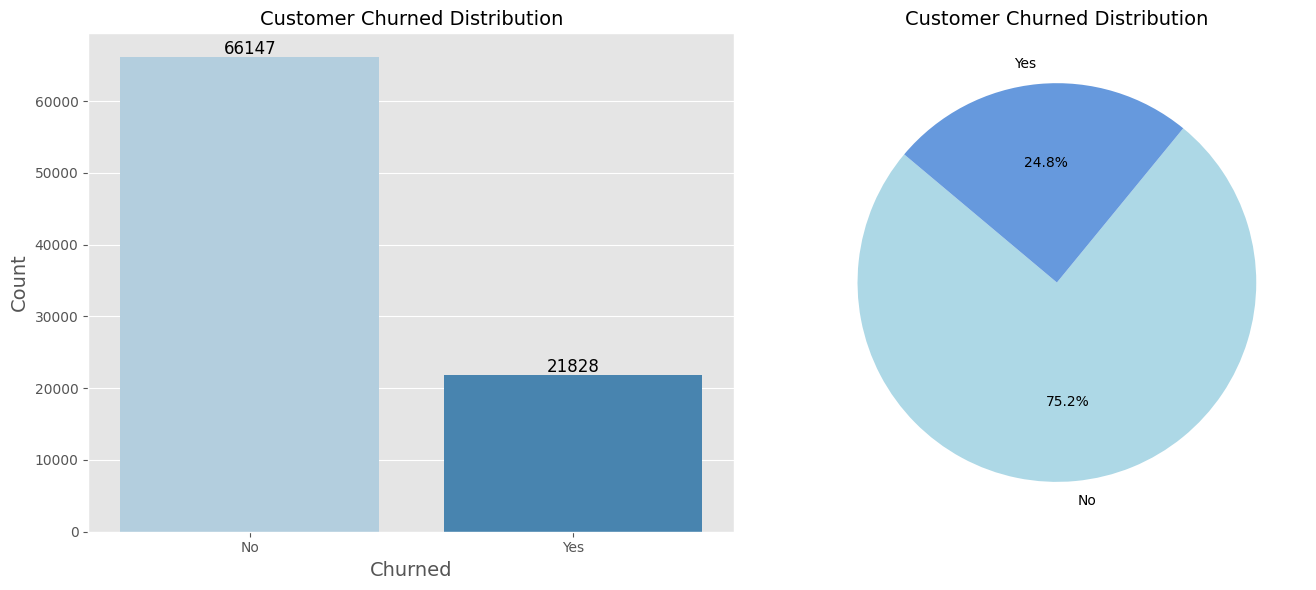

In [34]:
plt.figure(figsize=(14,6))
# Bar plot

plt.subplot(1, 2, 1)
ax1 = sns.countplot(data=recurrent_customers, x='churn_nominal', palette='Blues')
plt.title('Customer Churned Distribution', fontsize=14)
plt.xlabel('Churned', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add counts on top of bars
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height() + 200),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                 textcoords='offset points')

# Pie chart
plt.subplot(1, 2, 2)
churn_counts = recurrent_customers['churn_nominal'].value_counts()
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=140, colors=['lightBlue', '#69d'])
plt.title('Customer Churned Distribution', fontsize=14)

plt.tight_layout()
plt.show()

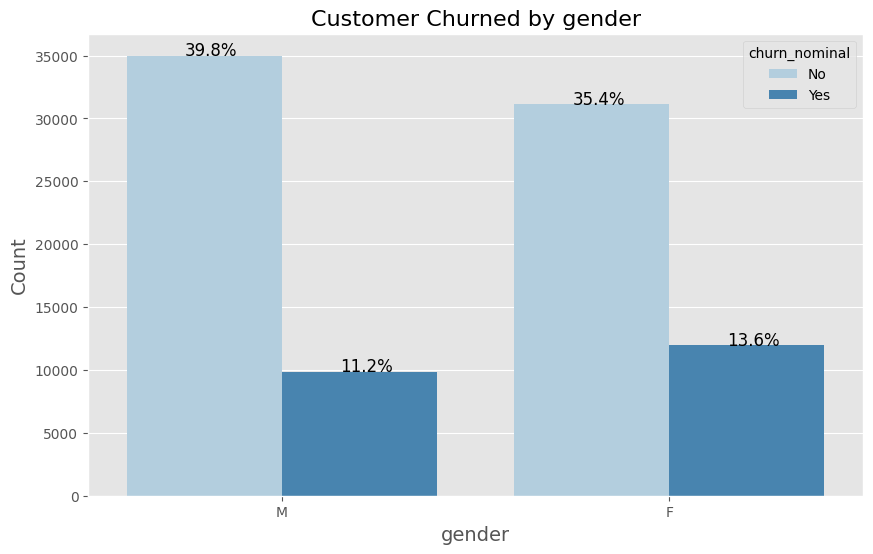

In [35]:
countplot('gender')

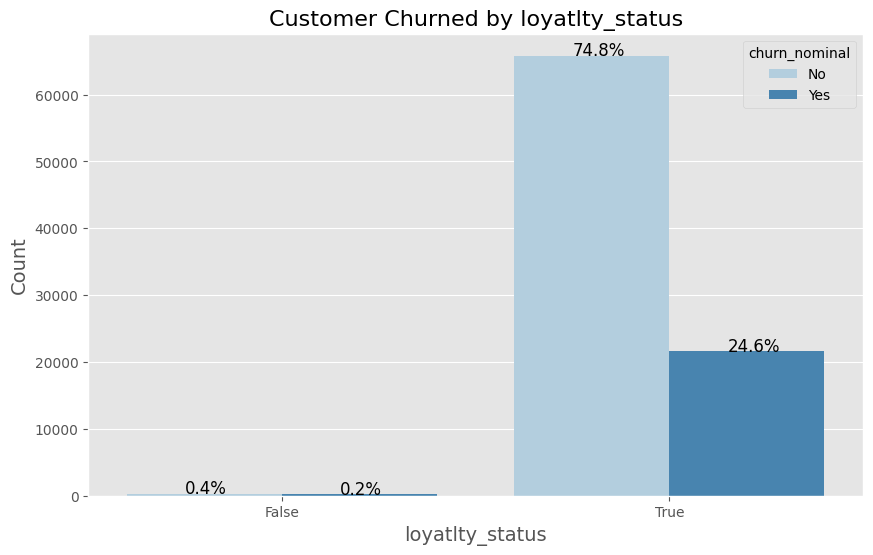

In [36]:
countplot('loyatlty_status')

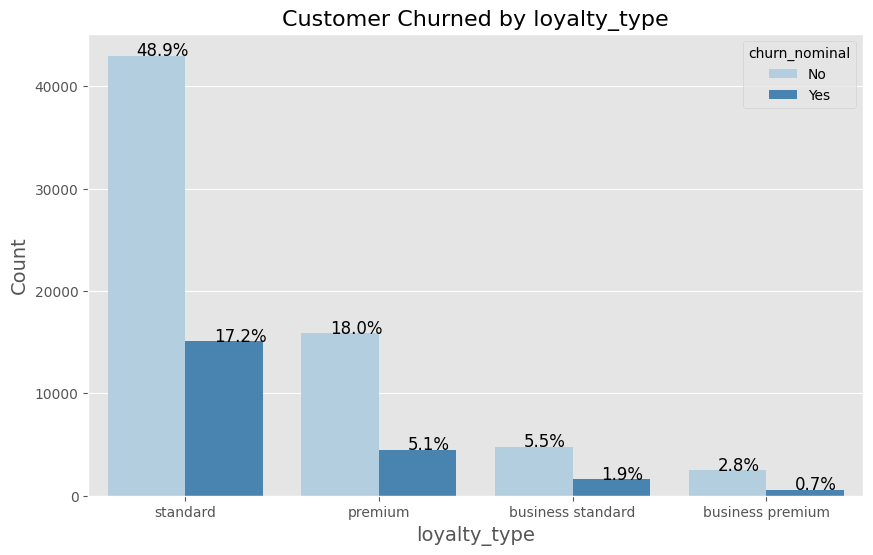

In [37]:
countplot('loyalty_type')

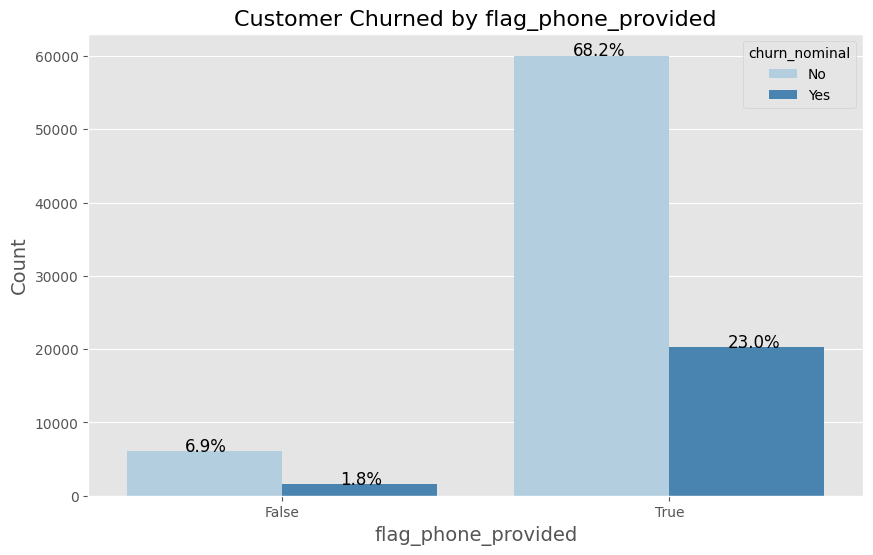

In [38]:
countplot('flag_phone_provided')

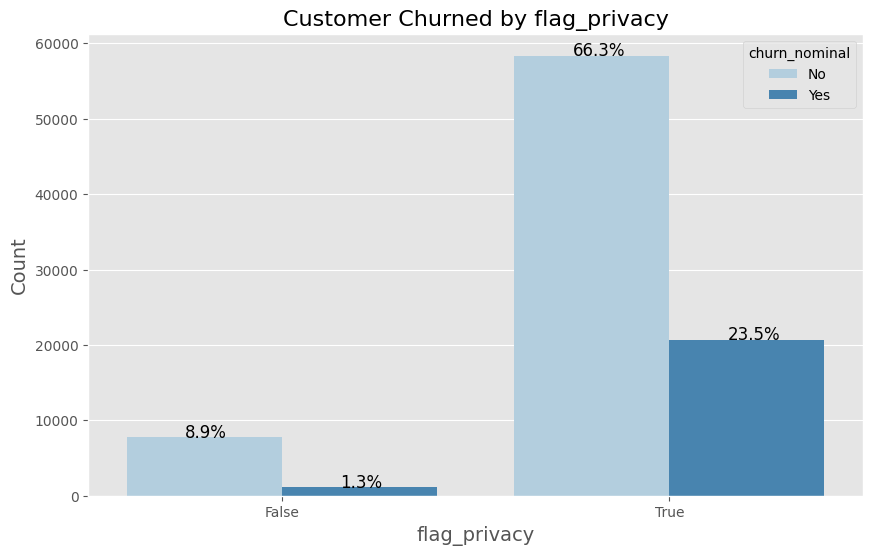

In [39]:
countplot('flag_privacy')

<ipython-input-4-8d9f6a7d00b9>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=recurrent_customers, x='churn_nominal', y=column, palette='Blues')


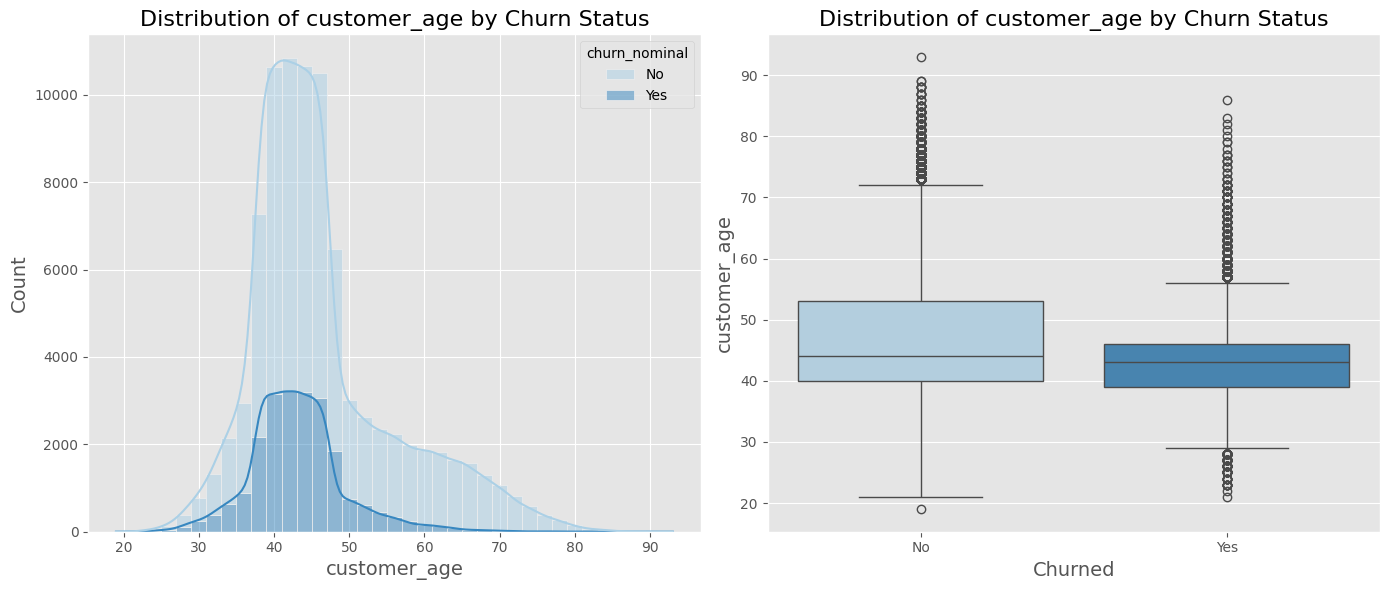

In [40]:
continous_plot('customer_age')

<ipython-input-4-8d9f6a7d00b9>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=recurrent_customers, x='churn_nominal', y=column, palette='Blues')


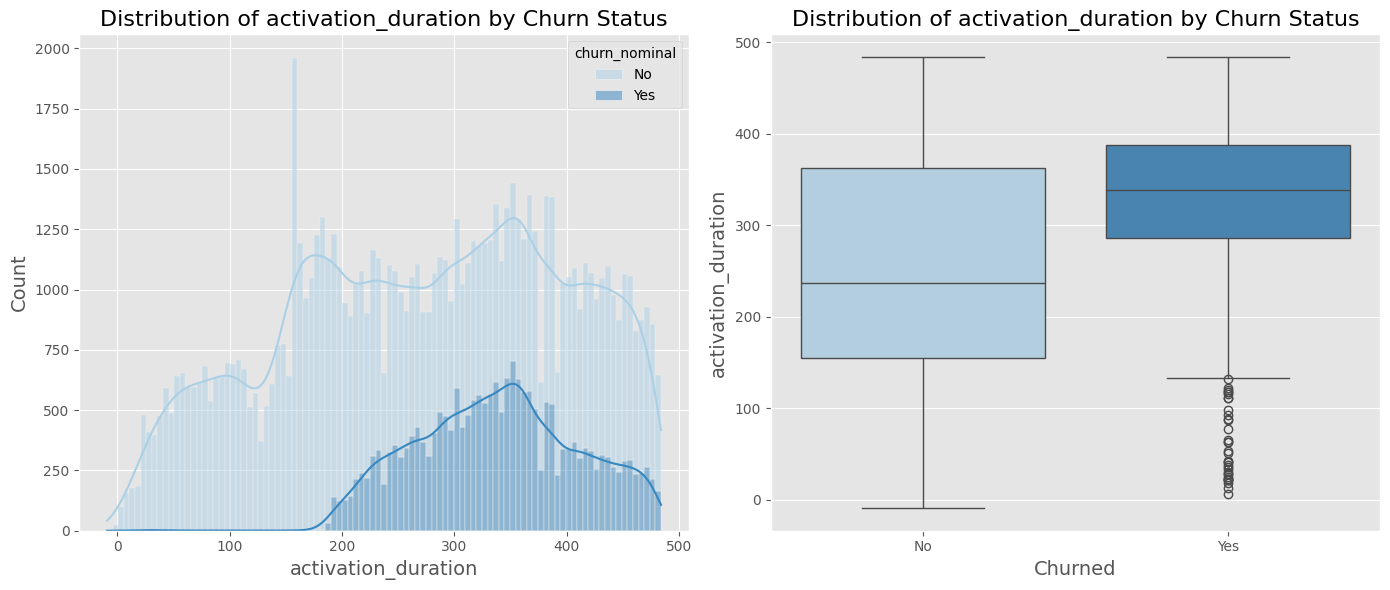

In [41]:
continous_plot('activation_duration', 5)

In [42]:
# Arrotondare per eccesso la colonna total_spending
recurrent_customers['total_spending'] = np.ceil(recurrent_customers['total_spending'])

In [43]:
recurrent_customers['total_spending'].astype(int)

0          29
1          42
2          80
3          19
4          96
         ... 
87970    1098
87971     930
87972     493
87973    1655
87974    1290
Name: total_spending, Length: 87975, dtype: int64

In [44]:
# Calculate IQR for num_purchases
Q1 = recurrent_customers['total_spending'].quantile(0.25)
Q3 = recurrent_customers['total_spending'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
outliers = recurrent_customers[(recurrent_customers['total_spending'] < lower_bound) | (recurrent_customers['total_spending'] > upper_bound)]
num_outliers = len(outliers)
num_outliers/recurrent_customers.shape[0]

0.1106223358908781

In [45]:
recurrent_customers = recurrent_customers[~((recurrent_customers['total_spending'] < lower_bound) | (recurrent_customers['total_spending'] > upper_bound))]

<ipython-input-4-8d9f6a7d00b9>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=recurrent_customers, x='churn_nominal', y=column, palette='Blues')


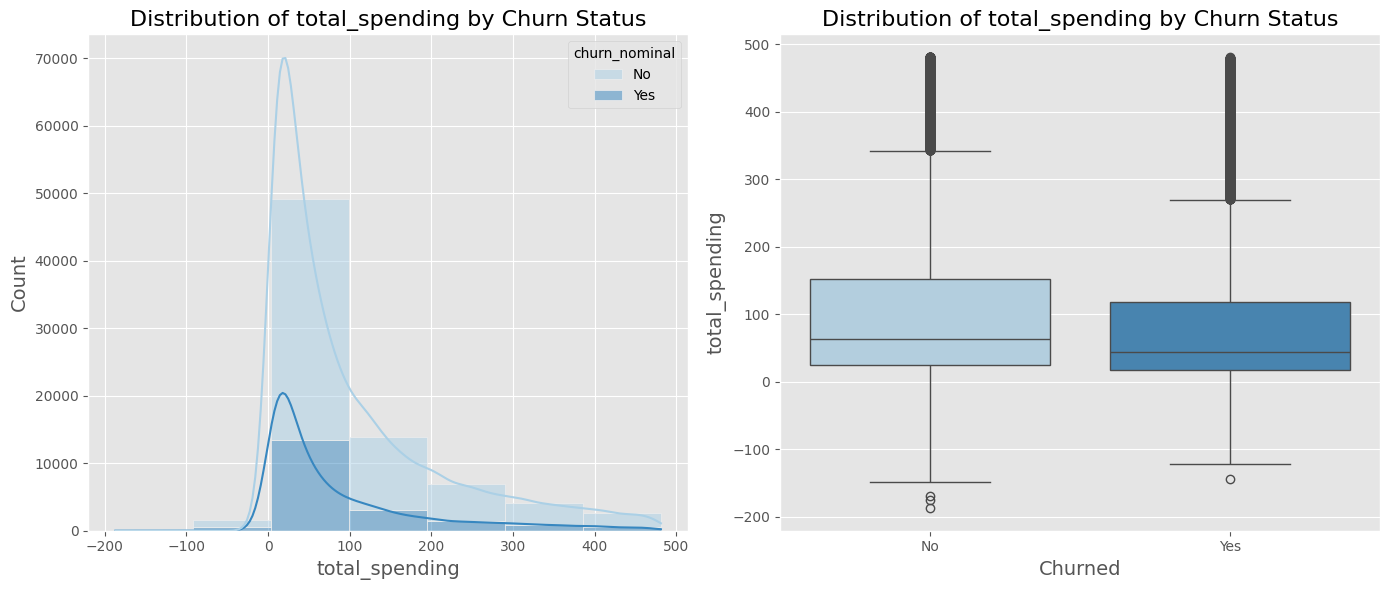

In [46]:
continous_plot('total_spending', 100)

In [47]:
# Calculate IQR for num_purchases
Q1 = recurrent_customers['num_purchases'].quantile(0.25)
Q3 = recurrent_customers['num_purchases'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
outliers = recurrent_customers[(recurrent_customers['num_purchases'] < lower_bound) | (recurrent_customers['num_purchases'] > upper_bound)]
num_outliers = len(outliers)

In [48]:
num_outliers/recurrent_customers.shape[0]

0.06510486561098118

Seems to be okay to exclude outliers

In [49]:
# Remove outliers
recurrent_customers_cleaned = recurrent_customers[~((recurrent_customers['num_purchases'] < lower_bound) | (recurrent_customers['num_purchases'] > upper_bound))]

Text(0, 0.5, 'Count')

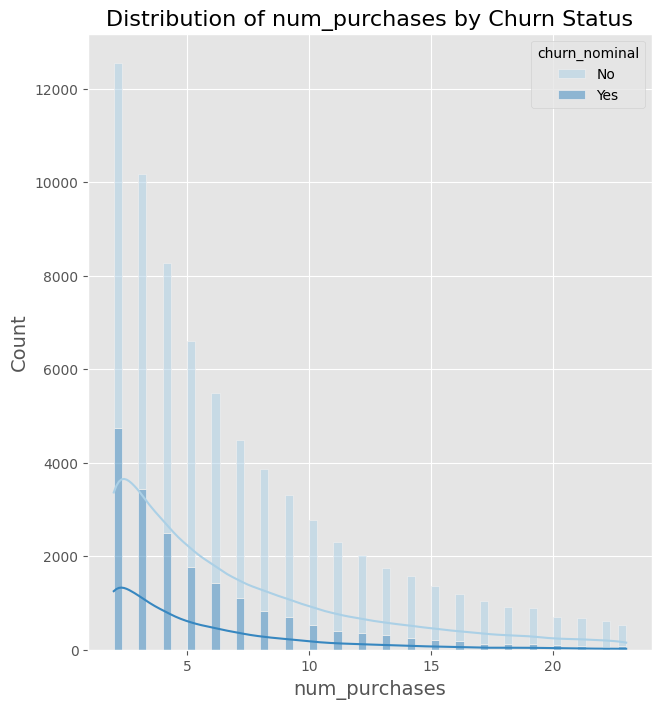

In [50]:
# Plot the distribution of log-transformed num_purchases by churn status
plt.figure(figsize=(16, 8))

# Histogram and KDE plot
plt.subplot(1, 2, 1)
sns.histplot(data=recurrent_customers_cleaned, x='num_purchases', hue='churn_nominal', kde=True, palette='Blues', multiple='stack')
plt.title('Distribution of num_purchases by Churn Status', fontsize=16)
plt.xlabel('num_purchases', fontsize=14)
plt.ylabel('Count', fontsize=14)

In [51]:
# Calculate IQR for num_purchases
Q1 = recurrent_customers['num_purchases'].quantile(0.25)
Q3 = recurrent_customers['num_purchases'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
outliers = recurrent_customers[(recurrent_customers['num_purchases'] < lower_bound) | (recurrent_customers['num_purchases'] > upper_bound)]
num_outliers = len(outliers)

In [52]:
recurrent_customers_cleaned['num_purchases']

0        12
1         6
2         2
3         4
4         4
         ..
87786    17
87790    22
87820    18
87888    16
87919    19
Name: num_purchases, Length: 73149, dtype: int64

In [53]:
cols = ['customer_age','activation_duration','num_purchases' ]
recurrent_customers_cleaned[cols].skew().to_frame().rename(columns={0:"Feature Skewness"})

,Feature Skewness
customer_age,1.195352
activation_duration,-0.202368
num_purchases,1.210178


In [54]:
recurrent_customers_cleaned["customer_age"] = np.log(recurrent_customers_cleaned["customer_age"])
recurrent_customers_cleaned["num_purchases"] = np.log(recurrent_customers_cleaned["num_purchases"])

<ipython-input-54-2fec068bb052>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recurrent_customers_cleaned["customer_age"] = np.log(recurrent_customers_cleaned["customer_age"])
<ipython-input-54-2fec068bb052>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recurrent_customers_cleaned["num_purchases"] = np.log(recurrent_customers_cleaned["num_purchases"])


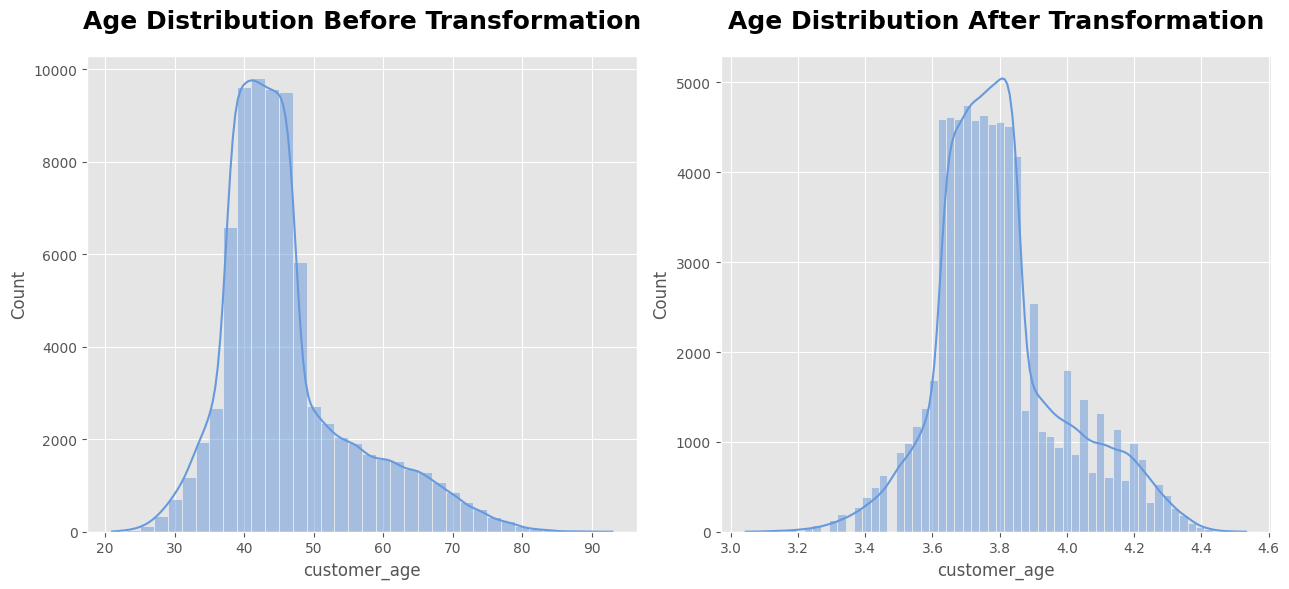

In [55]:
plt.figure(figsize=(13,6))
plt.subplot(1,2,1)
sns.histplot(recurrent_customers["customer_age"], color="#69d", kde=True, binwidth=2)
plt.title("Age Distribution Before Transformation",fontweight="black",size=18,pad=20)

plt.subplot(1,2,2)
sns.histplot(recurrent_customers_cleaned["customer_age"], color="#69d", kde=True, binwidth=0.025)
plt.title("Age Distribution After Transformation",fontweight="black",size=18,pad=20)
plt.tight_layout()
plt.show()

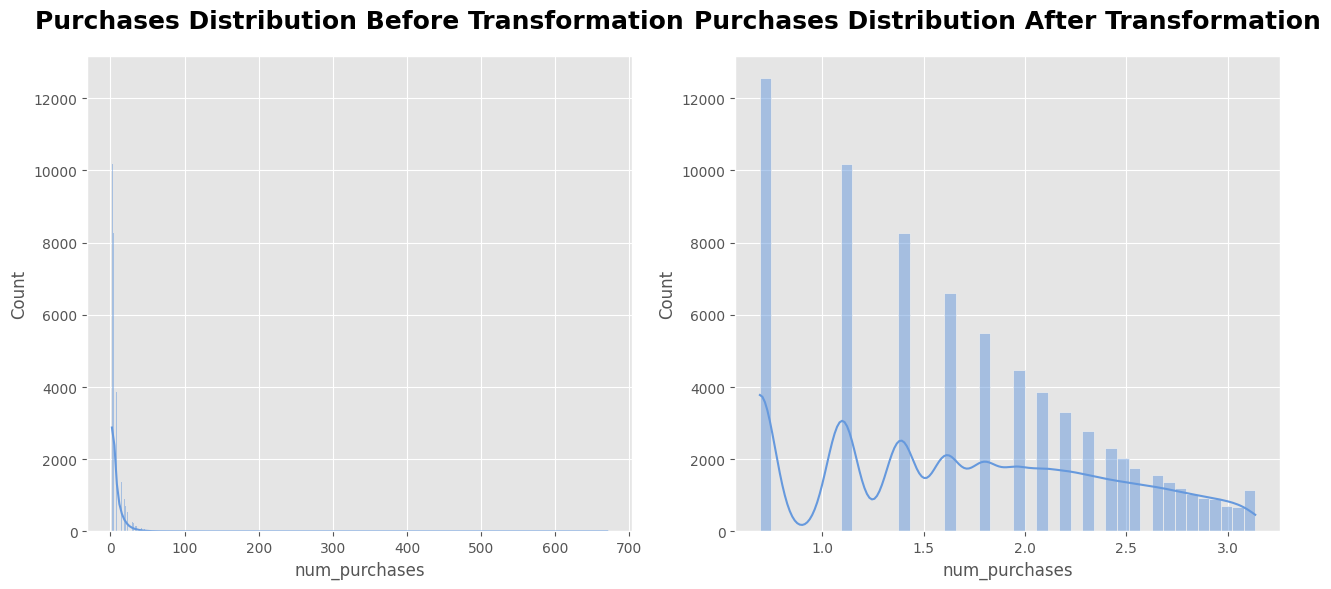

In [56]:
plt.figure(figsize=(13,6))
plt.subplot(1,2,1)
sns.histplot(recurrent_customers["num_purchases"], color="#69d", kde=True)
plt.title("Purchases Distribution Before Transformation",fontweight="black",size=18,pad=20)

plt.subplot(1,2,2)
sns.histplot(recurrent_customers_cleaned["num_purchases"], color="#69d", kde=True)
plt.title("Purchases Distribution After Transformation",fontweight="black",size=18,pad=20)
plt.tight_layout()
plt.show()

In [57]:
recurrent_customers_cleaned.dtypes

customer_id                       int64
address_id                        int64
birthdate                datetime64[ns]
gender                           object
flag_phone_provided                bool
flag_privacy                       bool
account_id                        int64
favorite_store                    int64
loyalty_type                     object
loyatlty_status                    bool
activation_date          datetime64[ns]
postal_code                      object
district                         object
region                           object
customer_age                    float64
activation_duration               int64
total_spending                  float64
purchase_datetime        datetime64[ns]
num_purchases                   float64
time_to_last_purchase             int64
churn                             int64
churn_nominal                    object
dtype: object

## Feature selection

In [58]:
cols_to_drop = ['customer_id','address_id','birthdate','activation_date','account_id', 'postal_code','purchase_datetime','churn', 'churn_nominal','time_to_last_purchase']

In [59]:
# Encode categorical variables
label_encoder = LabelEncoder()
recurrent_customers_cleaned['gender'] = label_encoder.fit_transform(recurrent_customers_cleaned['gender'])
recurrent_customers_cleaned['loyalty_type'] = label_encoder.fit_transform(recurrent_customers_cleaned['loyalty_type'])
recurrent_customers_cleaned['region'] = label_encoder.fit_transform(recurrent_customers_cleaned['region'])
recurrent_customers_cleaned['district'] = label_encoder.fit_transform(recurrent_customers_cleaned['district'])
recurrent_customers_cleaned['flag_phone_provided'] = label_encoder.fit_transform(recurrent_customers_cleaned['flag_phone_provided'])
recurrent_customers_cleaned['flag_privacy'] = label_encoder.fit_transform(recurrent_customers_cleaned['flag_privacy'])
recurrent_customers_cleaned['loyatlty_status'] = label_encoder.fit_transform(recurrent_customers_cleaned['loyatlty_status'])

<ipython-input-59-d7667c40dd3b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recurrent_customers_cleaned['gender'] = label_encoder.fit_transform(recurrent_customers_cleaned['gender'])
<ipython-input-59-d7667c40dd3b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recurrent_customers_cleaned['loyalty_type'] = label_encoder.fit_transform(recurrent_customers_cleaned['loyalty_type'])
<ipython-input-59-d7667c40dd3b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [60]:
# Separate majority and minority classes
majority_class = recurrent_customers_cleaned[recurrent_customers_cleaned.churn == 0]
minority_class = recurrent_customers_cleaned[recurrent_customers_cleaned.churn == 1]

# Downsample majority class
majority_downsampled = resample(majority_class,
                                replace=False,    # sample without replacement
                                n_samples=len(minority_class),  # to match minority class
                                random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
downsampled_df = pd.concat([majority_downsampled, minority_class])

# Separate features and target variable from the downsampled dataframe
X_downsampled = downsampled_df.drop(columns = cols_to_drop)
y_downsampled = downsampled_df['churn']

In [61]:
x_train,x_test,y_train,y_test = train_test_split(X_downsampled,y_downsampled,test_size=0.2,random_state=0)
print("Shape of x_train is:",x_train.shape)
print("Shape of x_test is: ",x_test.shape)
print("Shape of y_train is:",y_train.shape)
print("Shape of y_test is: ",y_test.shape)

Shape of x_train is: (31110, 12)
Shape of x_test is:  (7778, 12)
Shape of y_train is: (31110,)
Shape of y_test is:  (7778,)


In [62]:
y_train.value_counts().to_frame()

,count
churn,
0,15579
1,15531


## Decision Tree

In [63]:
dtree = DecisionTreeClassifier()

In [64]:
param_grid = {"max_depth":[4,5,7,9,10],
              "min_samples_split":[2,4,6,7,8],
              "min_samples_leaf":[1,3,5,7,8],
              "criterion":["gini","entropy"],
              "splitter":["best","random"],
              "max_features":["auto",None],
              "random_state":[0,42]}

In [65]:
x_train.dtypes

gender                   int64
flag_phone_provided      int64
flag_privacy             int64
favorite_store           int64
loyalty_type             int64
loyatlty_status          int64
district                 int64
region                   int64
customer_age           float64
activation_duration      int64
total_spending         float64
num_purchases          float64
dtype: object

In [66]:
# grid_search = GridSearchCV(dtree, param_grid, cv=5, n_jobs=-1)

# grid_search.fit(x_train,y_train)

In [67]:
# best_parameters = grid_search.best_params_

# print("Best Parameters for DecisionTree Model is:\n\n")
# best_parameters

In [68]:
best_parameters = {'criterion': 'gini',
 'max_depth': 8,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'random_state': 0,
 'splitter': 'best'}

In [69]:
dtree = DecisionTreeClassifier(**best_parameters)

dtree.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=3,
                       random_state=0)

Accuracy: 0.7526
F1 Score: 0.7470
Log Loss: 0.5637


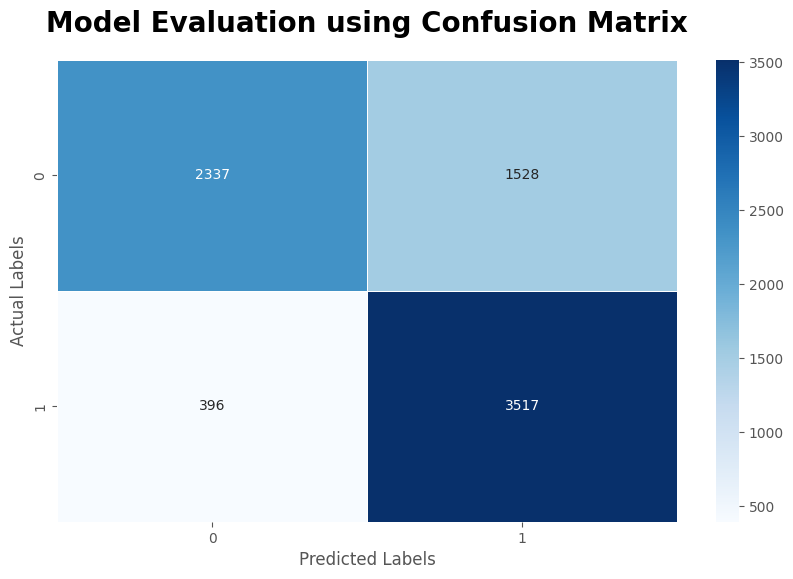

In [70]:
evaluate_model(dtree,x_test,y_test)

In [71]:
imp_df = pd.DataFrame({"Feature Name":x_train.columns,
                       "Importance":dtree.feature_importances_})

<ipython-input-72-326a461b68d8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature Name", data=features, palette="Blues")


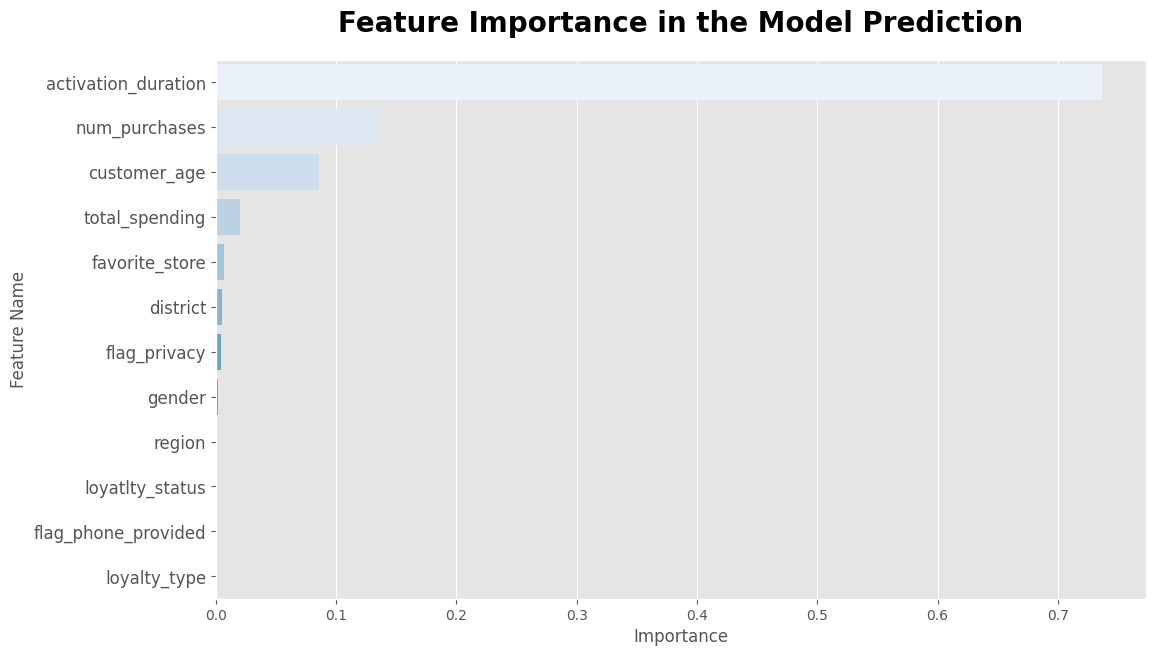

In [72]:
features = imp_df.sort_values(by="Importance",ascending=False)

plt.figure(figsize=(12,7))
sns.barplot(x="Importance", y="Feature Name", data=features, palette="Blues")
plt.title("Feature Importance in the Model Prediction", fontweight="black", size=20, pad=20)
plt.yticks(size=12)
plt.show()

In [73]:
# Add a constant column to the features
X_with_constant = add_constant(X_downsampled)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X_with_constant.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]

# Display VIF
print(vif_data)

                Feature         VIF
0                 const  709.807995
1                gender    1.018001
2   flag_phone_provided    1.015214
3          flag_privacy    1.045518
4        favorite_store    1.028825
5          loyalty_type    1.044434
6       loyatlty_status    1.001423
7              district    1.114057
8                region    1.109017
9          customer_age    1.076589
10  activation_duration    1.035582
11       total_spending    1.272271
12        num_purchases    1.264257


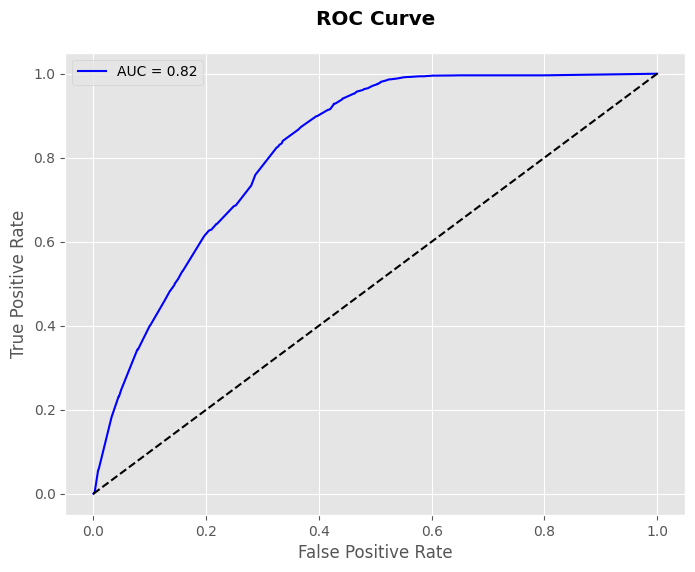

In [74]:
y_pred_proba = dtree.predict_proba(x_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=["y_actual"])])
df_actual_predicted.index = y_test.index


fpr, tpr, thresholds = roc_curve(df_actual_predicted["y_actual"], y_pred_proba)
auc = roc_auc_score(df_actual_predicted["y_actual"], y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}",color="Blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve",pad=20,fontweight="black")
plt.legend()
plt.show()

## Random forest

In [75]:
rfc = RandomForestClassifier()

In [76]:
param_grid = {"max_depth":[6,7,8],
              "min_samples_split":[6,7,8],
              "min_samples_leaf":[5,6,7,8],
              "n_estimators": [70,90,100],
              "criterion":["gini","entropy"]}

In [77]:
# grid_search = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1)

# grid_search.fit(x_train,y_train)

In [78]:
# best_parameters = grid_search.best_params_

# print("Best Parameters for RandomForest Model is:\n\n")
# best_parameters

In [79]:
best_parameters_rf = {'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 7,
 'min_samples_split': 9,
 'n_estimators': 100}

In [80]:
rfc = RandomForestClassifier(**best_parameters_rf)

rfc.fit(x_train,y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=7, min_samples_split=9)

In [81]:
def evaluate_model(model, x_test, y_test):
    # Predict the probabilities
    y_pred_prob = model.predict_proba(x_test)
    # Predict the classes
    y_pred_class = model.predict(x_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred_class)
    # Calculate the F1 score
    f1 = f1_score(y_test, y_pred_class, average='weighted')
    # Calculate the log loss
    loss = log_loss(y_test, y_pred_prob)

    # Print the results
    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Log Loss: {loss:.4f}')

    cm = confusion_matrix(y_test,y_pred_class)

    plt.figure(figsize=(10,6))
    sns.heatmap(data=cm, linewidth=.5, annot=True, fmt="g", cmap="Blues")
    plt.title("Model Evaluation using Confusion Matrix",fontsize=20,pad=20,fontweight="black")
    plt.ylabel("Actual Labels")
    plt.xlabel("Predicted Labels")
    plt.show()


Accuracy: 0.7607
F1 Score: 0.7548
Log Loss: 0.4719


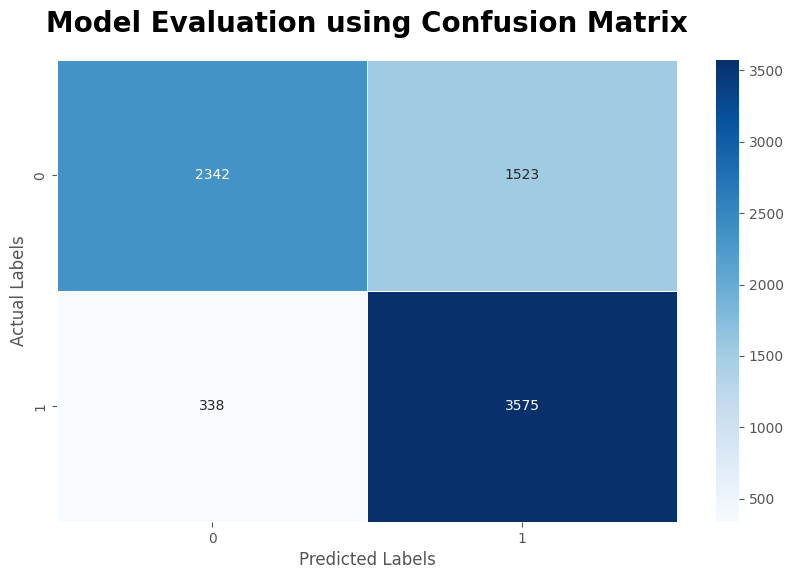

In [82]:
evaluate_model(rfc,x_test,y_test)

In [83]:
imp_df = pd.DataFrame({"Feature Name":x_train.columns,
                       "Importance":rfc.feature_importances_})

<ipython-input-84-5796ee07a3d6>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature Name", data=features, palette="plasma")


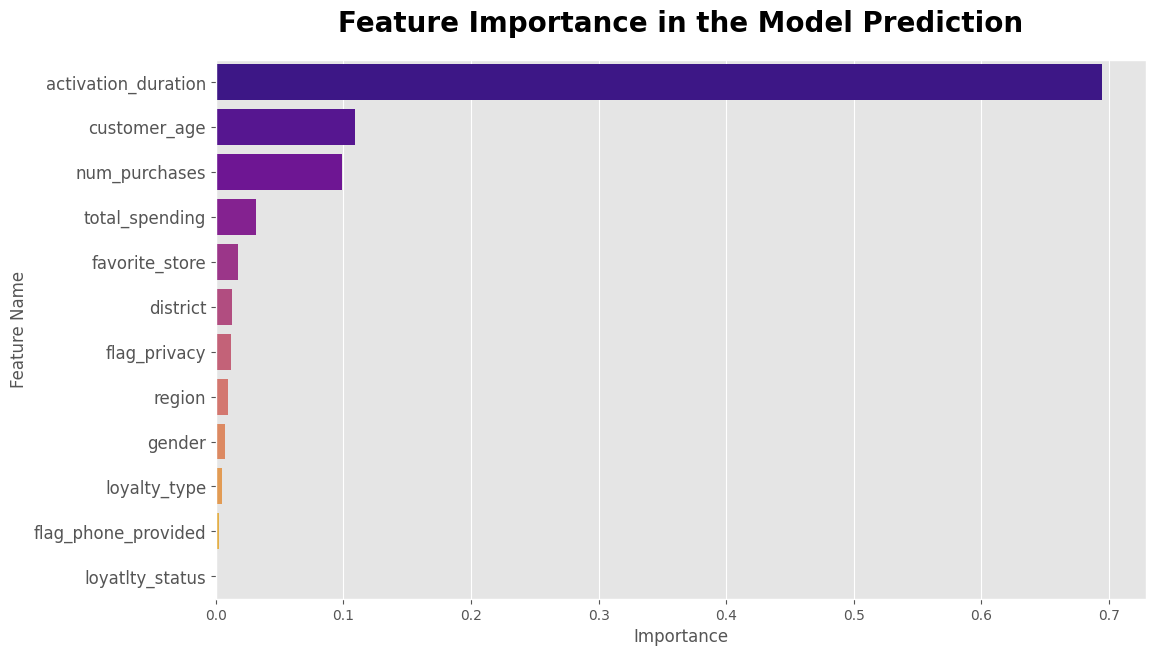

In [84]:
features = imp_df.sort_values(by="Importance",ascending=False)

plt.figure(figsize=(12,7))
sns.barplot(x="Importance", y="Feature Name", data=features, palette="plasma")
plt.title("Feature Importance in the Model Prediction", fontweight="black", size=20, pad=20)
plt.yticks(size=12)
plt.show()

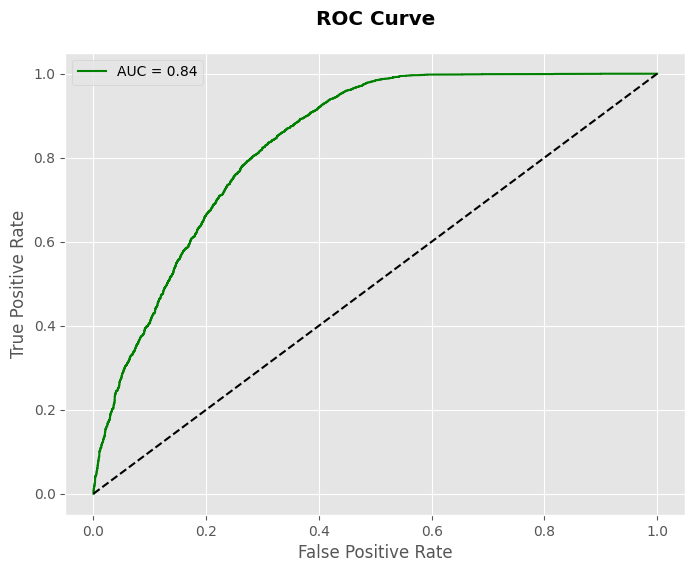

In [85]:
y_pred_proba = rfc.predict_proba(x_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=["y_actual"])])
df_actual_predicted.index = y_test.index


fpr, tpr, thresholds = roc_curve(df_actual_predicted["y_actual"], y_pred_proba)
auc = roc_auc_score(df_actual_predicted["y_actual"], y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}",color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve",pad=20,fontweight="black")
plt.legend()
plt.show()

## XGboost

In [86]:
model_xgboost = XGBClassifier()

In [87]:
model_xgboost.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Accuracy: 0.7552
F1 Score: 0.7529
Log Loss: 0.4796


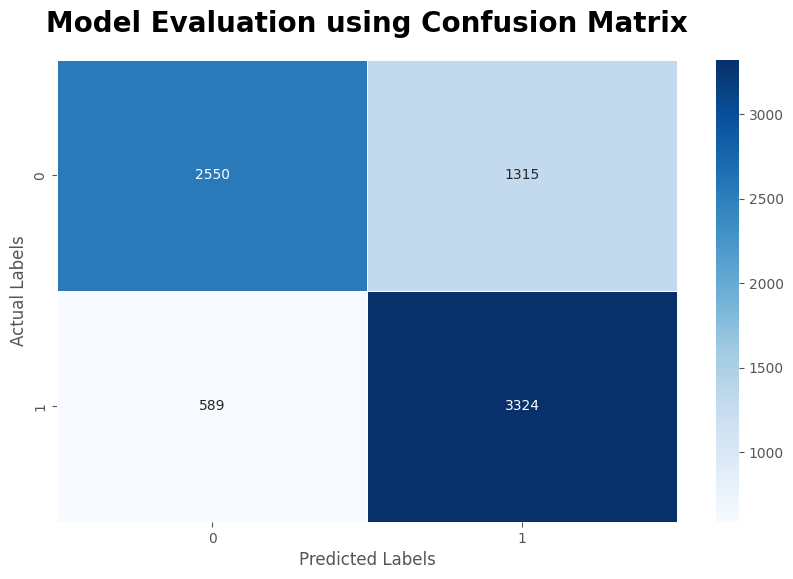

In [88]:
evaluate_model(model_xgboost,x_test,y_test)

In [89]:
y_train_pred_xgb = model_xgboost.predict(x_train)
y_pred_xgb = model_xgboost.predict(x_test)

In [90]:
print("Accuracy Score of Model on Training Data is =>",round(accuracy_score(y_train,y_train_pred_xgb)*100,2),"%")
print("Accuracy Score of Model on Testing Data  is =>",round(accuracy_score(y_test,y_pred_xgb)*100,2),"%")

Accuracy Score of Model on Training Data is => 82.49 %
Accuracy Score of Model on Testing Data  is => 75.52 %


In [91]:
print("F1 Score of the Model is =>",f1_score(y_test,y_pred_xgb,average="micro"))
print("Recall Score of the Model is =>",recall_score(y_test,y_pred_xgb,average="micro"))
print("Precision Score of the Model is =>",precision_score(y_test,y_pred_xgb,average="micro"))

F1 Score of the Model is => 0.7552069940858832
Recall Score of the Model is => 0.7552069940858832
Precision Score of the Model is => 0.7552069940858832


In [92]:
imp_xgb = pd.DataFrame({"Feature Name":x_train.columns,
                       "Importance":model_xgboost.feature_importances_})

<ipython-input-93-5796ee07a3d6>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature Name", data=features, palette="plasma")


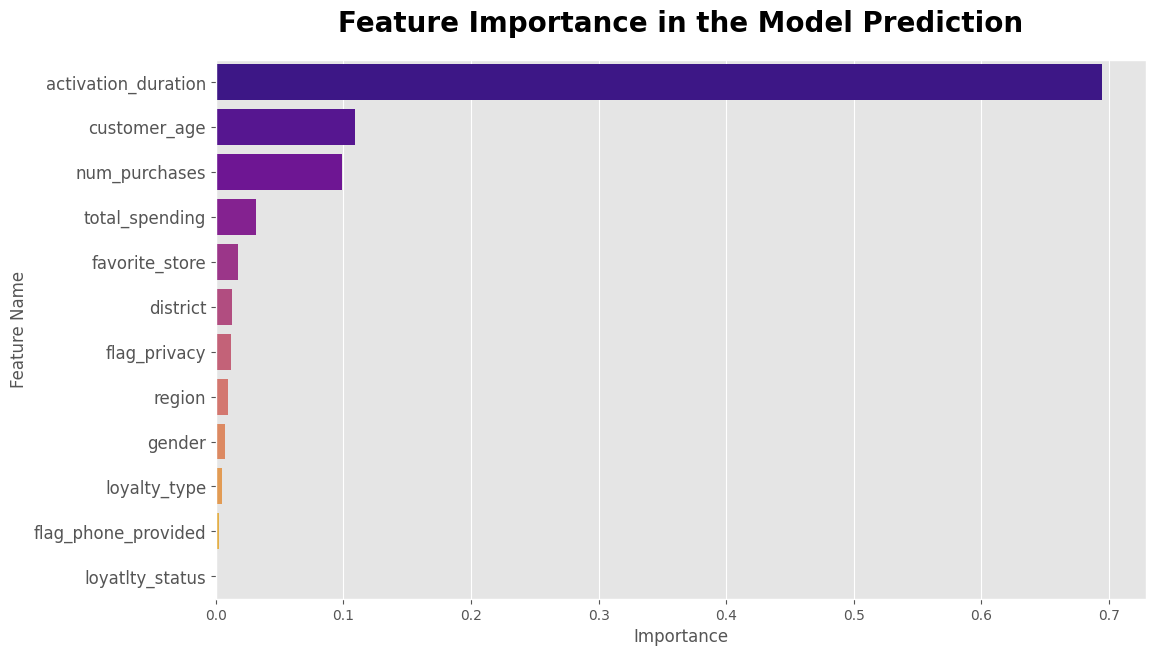

In [93]:
features = imp_df.sort_values(by="Importance",ascending=False)

plt.figure(figsize=(12,7))
sns.barplot(x="Importance", y="Feature Name", data=features, palette="plasma")
plt.title("Feature Importance in the Model Prediction", fontweight="black", size=20, pad=20)
plt.yticks(size=12)
plt.show()

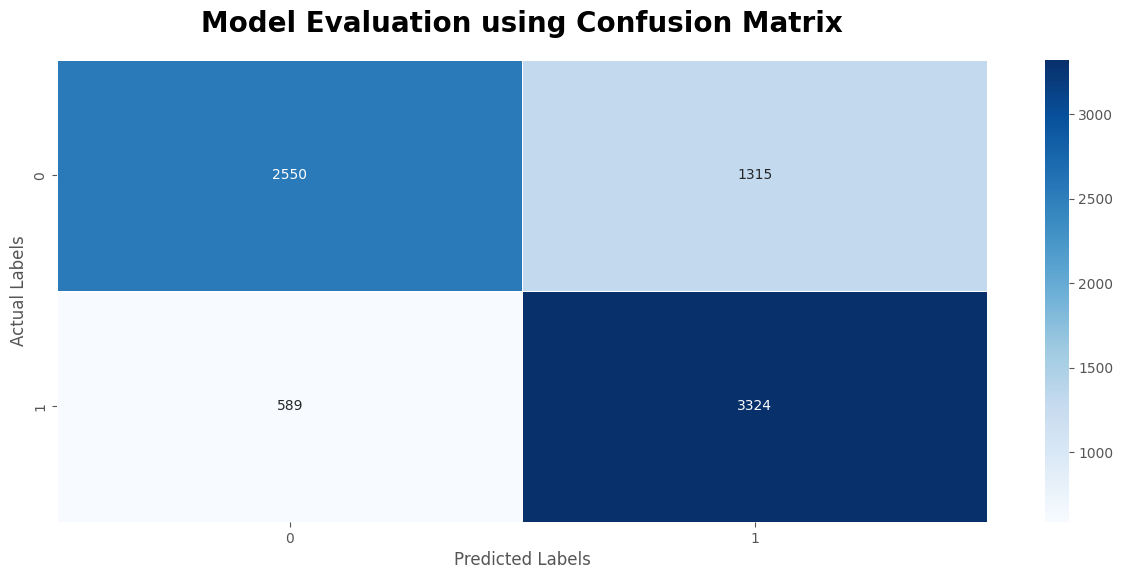

In [94]:
cm = confusion_matrix(y_test,y_pred_xgb)

plt.figure(figsize=(15,6))
sns.heatmap(data=cm, linewidth=.5, annot=True, fmt="g", cmap="Blues")
plt.title("Model Evaluation using Confusion Matrix",fontsize=20,pad=20,fontweight="black")
plt.ylabel("Actual Labels")
plt.xlabel("Predicted Labels")
plt.show()

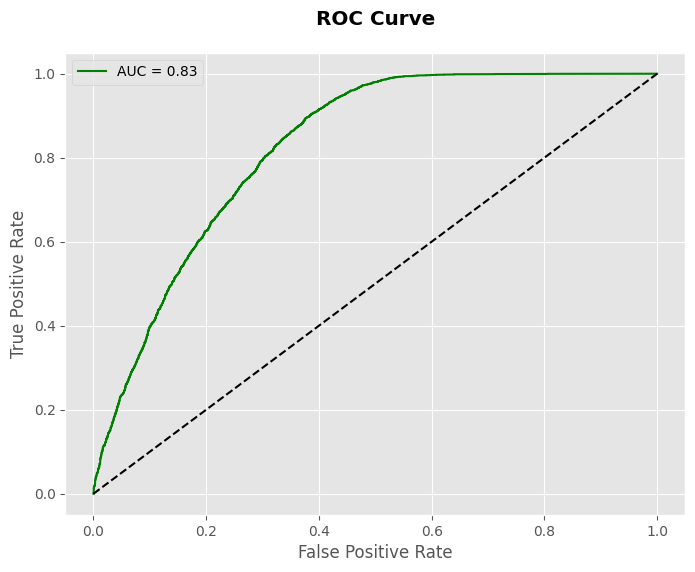

In [95]:
y_pred_proba = model_xgboost.predict_proba(x_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=["y_actual"])])
df_actual_predicted.index = y_test.index


fpr, tpr, thresholds = roc_curve(df_actual_predicted["y_actual"], y_pred_proba)
auc = roc_auc_score(df_actual_predicted["y_actual"], y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}",color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve",pad=20,fontweight="black")
plt.legend()
plt.show()

# Output
Export id of churn customers

In [96]:
# Percorso di Google Drive dove salvare il file
csv_file_path = dir + '/churned_customers.csv'

# Salva il dataframe in un file CSV
churned.to_csv(csv_file_path, index=False)

In [97]:
csv_file_path = dir + '/recurrent_customers.csv'
recurrent_customers.to_csv(csv_file_path, index=False)